In [1]:
#importa as bibliotecas necessárias
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import time
import statistics as st

In [2]:
#carrega dados
num_agentes = int(np.genfromtxt('m.csv', delimiter=","))
num_tarefas = int(np.genfromtxt('n.csv', delimiter=","))
mat_recurso_agente = np.genfromtxt('a.csv', delimiter=',')
mat_custo_tarefa = np.genfromtxt('c.csv', delimiter=',')
vet_capacidade = np.genfromtxt('b.csv', delimiter=',')

In [3]:
#restrição de capacidade dos agentes
#return 1 -> restrição quebrada
def restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao):
    agente = 0

    while (agente < num_agentes):
      esforco = 0
      tarefa = 0
      while (tarefa < num_tarefas ):
        esforco = esforco + mat_solucao[agente,tarefa]*mat_recurso_agente[agente,tarefa]
        tarefa += 1

      if (esforco > vet_capacidade[agente]):
        return 1

      agente += 1

    return 0

In [4]:
#restrição de cada tarefa ser atribuída a um único agente
#flag_tarefa = 1 -> restrição quebrada
def restricao_tarefa(num_agentes, num_tarefas, mat_solucao):
    flag_tarefa = 0
    i = 0
    j = 0
    while (j < num_tarefas and flag_tarefa == 0):
        soma = 0
        while (i < num_agentes and flag_tarefa == 0):
            soma = soma + mat_solucao[i,j]
            if (soma > 1):
                flag_tarefa = 1
            i+=1
        j+=1
    return flag_tarefa

In [5]:
#função objetivo fe()
def fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao):
    maior_esforco = 0
    menor_esforco = 10000
    agente = 0
    
    while (agente < num_agentes):
      esforco = 0
      tarefa = 0
      while (tarefa < num_tarefas ):
        esforco = esforco + mat_solucao[agente,tarefa]*mat_recurso_agente[agente,tarefa]
        tarefa += 1
      if (esforco > maior_esforco):
        maior_esforco = esforco.copy()
      elif (esforco < menor_esforco):
        menor_esforco = esforco.copy()
      agente += 1
    
    diferenca = maior_esforco - menor_esforco

    if (restricao_tarefa(num_agentes, num_tarefas, mat_solucao) == 1):
        diferenca = diferenca + 200
    if (restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) == 1):
        diferenca = diferenca + 200

    return diferenca

In [6]:
#gera uma solucação inicial factível para o problema
def solucao_inicial(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade):
    mat_solucao_inicial = np.zeros((num_agentes, num_tarefas), int)
    vet_tarefa_concluida = np.zeros(50)
    agente = 0
    while (agente < num_agentes):
        esforco = 0
        tarefa = 0
        while (tarefa < num_tarefas):
            esforco = esforco + mat_recurso_agente[agente,tarefa]
            if (vet_tarefa_concluida[tarefa] == 0 and esforco <= vet_capacidade[agente]):
                vet_tarefa_concluida[tarefa] = 1
                mat_solucao_inicial[agente][tarefa] = 1
            else:
                esforco = esforco - mat_recurso_agente[agente,tarefa]
            tarefa+=1
        agente+=1
    
    return mat_solucao_inicial

In [7]:
#define as cinco estruturas de vizinhança
def vizinhanca(num_agentes, num_tarefas, mat_solucao, vizinho, estagnacao, mat_recurso_agente):
    #seleciona aleatoriamente uma coluna e troca com a da direita
    if (vizinho == 1): 
        tarefa = random.randint(0, num_tarefas-1)
        agente = random.randint(0, num_agentes-1)
        mat_solucao[:,tarefa] = 0
        mat_solucao[agente,tarefa] = 1

    #seleciona uma tarefa aleatoria e a atribui a um agente aleatorio
    elif (vizinho == 2):    
        coluna = random.randint(0,num_tarefas-2)

        aux = np.copy(mat_solucao[:,coluna+1])
        mat_solucao[:,coluna+1] = np.copy(mat_solucao[:,coluna])
        mat_solucao[:,coluna] = np.copy(aux)  
                  
    #seleciona aleatoriamente duas tarefas e troca seus agentes
    elif (vizinho == 3):
        tarefa1 = random.randint(0, num_tarefas-1)
        tarefa2 = random.randint(0, num_tarefas-1)
        aux = np.copy(mat_solucao[:, tarefa1])
        mat_solucao[:,tarefa1] = np.copy(mat_solucao[:, tarefa2])
        mat_solucao[:,tarefa2] = np.copy(aux)
      
    #troca todas as colunas com a coluna a sua direita
    elif (vizinho == 4):
        coluna = 0
        while (coluna < num_tarefas):
            linha = 0
            while (linha < num_agentes):
                aux = np.copy(mat_solucao[linha,coluna])
                mat_solucao[linha,coluna] = np.copy(mat_solucao[linha,coluna+1])
                mat_solucao[linha,coluna+1] = np.copy(aux)
                linha+=1
            coluna+=2           

    #seleciona aleatoriamente duas linhas e as troca 
    elif (vizinho == 5):
        agente1 = random.randint(0, num_agentes-1)
        agente2 = random.randint(0, num_agentes-1)
        aux = np.copy(mat_solucao[agente1, :])
        mat_solucao[agente1,:] = np.copy(mat_solucao[agente2, :])
        mat_solucao[agente2,:] = np.copy(aux)
    
    return mat_solucao

In [10]:
def SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade):
    #temperatura inicial
    tk = 100
    #contador de estágios estagnados
    estagios_estagnados = 0

    #contador de avaliações da função f()
    nfe = 0
    
    #encontrando a solução inicial (sem considerar as restrições de capacidade) e a definindo como melhor solução
    mat_solucao_inicial = np.copy(solucao_inicial(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade))

    diferenca_atual = fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao_inicial).copy()
    mat_solucao_atual = np.copy(mat_solucao_inicial)
    mat_melhor_solucao = np.copy(mat_solucao_inicial)

    menor_diferenca = diferenca_atual.copy()
    
    vet_diferencas = []
    vet_diferencas.append(diferenca_atual)
        
    while (estagios_estagnados <= 10 and nfe < 10000):

        num_aceites = 0
        num_tentativas = 0

        fevalin = menor_diferenca.copy()

        while (num_aceites < 12*num_tarefas and num_tentativas < 100*num_tarefas):

            vizinho = random.randint(1,5)
            mat_solucao_prox = vizinhanca(num_agentes, num_tarefas, mat_solucao_atual, vizinho, estagios_estagnados, mat_recurso_agente)
            diferenca_prox = fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao_prox)

            nfe+=1
            
            delta_e = diferenca_prox - diferenca_atual
            
            if (delta_e <= 0 or (random.uniform(0,1) <= math.exp(-delta_e/tk))):

                mat_solucao_atual = np.copy(mat_solucao_prox)
                diferenca_atual = diferenca_prox.copy()

                num_aceites+=1
                
                if (diferenca_atual < menor_diferenca):
                    mat_melhor_solucao = np.copy(mat_solucao_atual)
                    menor_diferenca = diferenca_atual.copy()
            
            num_tentativas+=1
            
            #armazena o custo corrente
            vet_diferencas.append(diferenca_atual)
            
        #atualiza a temperatura
        tk = 0.5*tk
        if (tk < 0.1):
            tk = 100
        
        #avalia critério de estagnação
        if (menor_diferenca < fevalin):
            estagios_estagnados = 0
        else:
            estagios_estagnados += 1
        
    plt.plot(vet_diferencas)
    plt.ylabel('Diferença de consumo de recurso')
    plt.xlabel('Iteração')
    plt.show()
    return mat_melhor_solucao, menor_diferenca, vet_diferencas

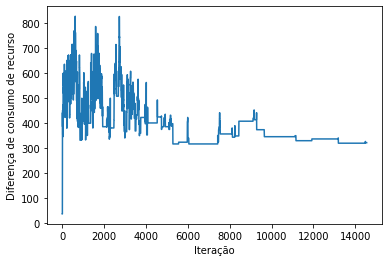

Tempo de execução: 30.313173055648804


In [24]:
inicio = time.time()
mat_melhor_solucao, menor_diferenca, vet_diferencas = SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade)
fim = time.time()
print('Tempo de execução:', fim - inicio)

In [12]:
#valida se a melhor solução quebrou a restrição de capacidade do agente
restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_melhor_solucao)

0

In [13]:
#valida se a melhor solução quebrou a restrição de uma tarefa para um único agente
restricao_tarefa(num_agentes, num_tarefas, mat_melhor_solucao)

0

In [25]:
print('Melhor diferença:', menor_diferenca)
print('Menor diferença:', min(vet_diferencas))
print('Maior diferença:', max(vet_diferencas))
print('Média:', st.mean(vet_diferencas))
print('Desvio padrão:', st.pstdev(vet_diferencas))

Melhor diferença: 36.0
Menor diferença: 36.0
Maior diferença: 827.0
Média: 385.21121726579145
Desvio padrão: 83.05918841782045
